## Portfolio simulation

In [49]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class2 import PortfolioSimulation2
import matplotlib.pyplot as plt
import re

In [50]:
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

- Function to preprocess signals to what the PF simulation class expects

In [51]:
def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

---
- Reading in the recommendations dfs

In [52]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Change strong_buy and strong_sell to buy and sell
analyst_ratings["rating"] = analyst_ratings["rating"].replace({"strong_buy": "buy", "strong_sell": "sell"})
analyst_ratings.head()

,cik,date,mean_rating,rating,security
0,0000001750,2000-01,1.71429,buy,AAR CORP.
1,0000001750,2000-02,1.71429,buy,AAR CORP.
2,0000001750,2000-03,1.71429,buy,AAR CORP.
3,0000001750,2000-04,1.50000,strong buy,AAR CORP.
4,0000001750,2000-05,1.50000,strong buy,AAR CORP.


In [53]:
# LLM recommendations with only most recent financial statements
llm_recommendations1 = pd.read_csv("../data/ciklist1_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations2 = pd.read_csv("../data/ciklist2_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations3 = pd.read_csv("../data/ciklist3_ratings_with_most_recent_quarters.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations = pd.concat([llm_recommendations1, llm_recommendations2, llm_recommendations3], ignore_index=True)
llm_recommendations.head()

,cik,date,rating
0,0001497645,2010-03-31,sell
1,0001497645,2010-06-30,sell
2,0001497645,2010-09-30,sell
3,0001497645,2010-12-31,sell
4,0001497645,2011-03-31,sell


In [54]:
# Read in LLM recommendations with previous quarters
llm_recommendations_w_prev_quarters1 = pd.read_csv("../data/ciklist1_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters2 = pd.read_csv("../data/ciklist2_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters3 = pd.read_csv("../data/ciklist3_ratings_with_previous_quarters.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations_w_prev_quarters = pd.concat([llm_recommendations_w_prev_quarters1, llm_recommendations_w_prev_quarters2, llm_recommendations_w_prev_quarters3])
llm_recommendations_w_prev_quarters.head()

,cik,date,rating
0,0001576018,2013-03-31,buy
1,0001576018,2013-06-30,hold
2,0001576018,2013-09-30,buy
3,0001576018,2013-12-31,hold
4,0001576018,2014-03-31,hold


In [55]:
len(analyst_ratings), len(llm_recommendations), len(llm_recommendations_w_prev_quarters)

(355900, 122031, 119731)

In [81]:
random_cik = llm_recommendations["cik"].sample().values[0]
llm_subset = llm_recommendations[llm_recommendations["cik"] == random_cik]
llm_prev_quarters_subset = llm_recommendations_w_prev_quarters[llm_recommendations_w_prev_quarters["cik"] == random_cik]
print(f"Looking at CIK: {random_cik}")

Looking at CIK: 0001058290


llm_prev_quarters empty for 0001140536

In [82]:
llm_subset

,cik,date,rating,action
13372,0001058290,1999-03,sell,sell
13373,0001058290,1999-06,buy,buy
13374,0001058290,1999-09,buy,buy
13375,0001058290,1999-12,strong buy,strong buy
13376,0001058290,2000-03,sell,sell
...,...,...,...,...
13467,0001058290,2022-12,buy,buy
13468,0001058290,2023-03,buy,buy
13469,0001058290,2023-06,sell,sell
13470,0001058290,2023-09,buy,buy


In [83]:
llm_prev_quarters_subset

,cik,date,rating,action


---

- Subsetting CIK date combinations that are present in all dataframes

In [58]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
llm_recommendations_w_prev_quarters["action"] = llm_recommendations_w_prev_quarters["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters["date"]).dt.to_period("M").astype(str)
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)
llm_recommendations_w_prev_quarters.drop_duplicates(subset=["cik", "date"], inplace=True)

In [59]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
llm_prev_quarters_ciks_and_dates = llm_recommendations_w_prev_quarters[["cik", "date"]].drop_duplicates()

# Merge to find common CIK and date combinations
llm_cik_and_dates_all = pd.merge(llm_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")
all_ciks_and_dates = pd.merge(llm_cik_and_dates_all, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [61]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_w_prev_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, all_ciks_and_dates, on=["cik", "date"], how="inner"
)


llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)
llm_recommendations_w_prev_quarters_final["date"] = llm_recommendations_w_prev_quarters_final["date"].astype(str)
len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(64010, 64010, 64010)

In [11]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    31671
buy     15674
sell    15405
Name: count, dtype: int64

In [12]:
llm_recommendations_final["action"].value_counts()

action
sell          28871
buy           25805
hold           8050
strong buy       24
Name: count, dtype: int64

In [13]:
analyst_ratings_final["rating"].value_counts()

rating
buy            39792
hold           19476
strong buy      3084
sell             388
strong sell       10
Name: count, dtype: int64

---
## Simulations

### LLM recomendations with most recent financial statements

In [14]:
# Set global variables for all simulations
start_capital = 10000000
transaction_cost_rate = 0.001

# Initialize portfolio simulation
llm_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim.load_dataframes(stock_prices, llm_recommendations_final, risk_free_rate_df)
# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 307/307 [13:18<00:00,  2.60s/it]


In [15]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [48:04<00:00,  9.36s/it]


In [16]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.012142),
 'Geometric mean return (monthly)': np.float64(0.011231),
 'Standard deviation (monthly)': np.float64(0.042781),
 'Annualized mean return': np.float64(0.155837),
 'Annualized standard deviation': np.float64(0.148198),
 'Number of buys': 25521,
 'Number of sells': 9036,
 'Number of holds': 8050,
 'Total number of transactions': 34557,
 'Number of skipped buys': 284,
 'Number of skipped sells': 19835,
 'Total number of skipped transactions': 27442,
 'Overall transaction count': 61999,
 'Number of recommendations': 62750,
 'Total amount of transaction costs': np.float64(992388.985473)}

---

### LLM recommendations with previous quarters

In [17]:
# Initialize portfolio simulation
llm_sim2 = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim2.load_dataframes(stock_prices, llm_recommendations_w_prev_quarters_final, risk_free_rate_df)

# Run simulation
llm_sim2.simulate_trading()

Simulating Trades: 100%|██████████| 307/307 [07:10<00:00,  1.40s/it]


In [18]:
llm_returns2 = llm_sim2.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [47:30<00:00,  9.26s/it]


In [19]:
llm_sim2.portfolio_statistics(monthly_returns =  llm_returns2)

{'Mean return (monthly)': np.float64(0.008152),
 'Geometric mean return (monthly)': np.float64(0.00755),
 'Standard deviation (monthly)': np.float64(0.034762),
 'Annualized mean return': np.float64(0.102335),
 'Annualized standard deviation': np.float64(0.12042),
 'Number of buys': 15276,
 'Number of sells': 3853,
 'Number of holds': 31671,
 'Total number of transactions': 19129,
 'Number of skipped buys': 398,
 'Number of skipped sells': 11552,
 'Total number of skipped transactions': 43059,
 'Overall transaction count': 62188,
 'Number of recommendations': 62750,
 'Total amount of transaction costs': np.float64(190025.463924)}

In [29]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    31671
buy     15674
sell    15405
Name: count, dtype: int64

---
### Analyst recommendations simulation

In [20]:
analyst_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate = 0 )
analyst_sim.load_dataframes(stock_prices, analyst_ratings_final, risk_free_rate_df)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 307/307 [09:25<00:00,  1.84s/it]


In [21]:
len(stock_prices), len(analyst_ratings_final)

(355365, 62750)

In [22]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [09:24<00:00,  1.83s/it]


In [23]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.01146),
 'Geometric mean return (monthly)': np.float64(0.0102),
 'Standard deviation (monthly)': np.float64(0.050331),
 'Annualized mean return': np.float64(0.146526),
 'Annualized standard deviation': np.float64(0.174352),
 'Number of buys': 255,
 'Number of sells': 7,
 'Number of holds': 19476,
 'Total number of transactions': 262,
 'Number of skipped buys': 39537,
 'Number of skipped sells': 391,
 'Total number of skipped transactions': 58924,
 'Overall transaction count': 59186,
 'Number of recommendations': 62750,
 'Total amount of transaction costs': np.float64(0.0)}

In [26]:
analyst_ratings_final["action"].value_counts()

action
buy           39792
hold          19476
strong buy     3084
sell            398
Name: count, dtype: int64

In [32]:
analyst_sim.initial_capital

10000000

In [24]:
analyst_sim.skipped_transactions

[('0000006845', Period('2000-02', 'M'), 'Hold signal - no action taken'),
 ('0000075288', Period('2000-02', 'M'), 'Hold signal - no action taken'),
 ('0000836157', Period('2000-02', 'M'), 'Hold signal - no action taken'),
 ('0000886982', Period('2000-02', 'M'), 'Hold signal - no action taken'),
 ('0000923120', Period('2000-02', 'M'), 'Hold signal - no action taken'),
 ('0000836157', Period('2000-05', 'M'), 'Hold signal - no action taken'),
 ('0000886982', Period('2000-05', 'M'), 'Hold signal - no action taken'),
 ('0000923120', Period('2000-05', 'M'), 'Hold signal - no action taken'),
 ('0000815097',
  Period('2000-05', 'M'),
  'Not enough allocation for one share incl. fees'),
 ('0000866787',
  Period('2000-05', 'M'),
  'Not enough allocation for one share incl. fees'),
 ('0000895421',
  Period('2000-05', 'M'),
  'Not enough allocation for one share incl. fees'),
 ('0000909832',
  Period('2000-05', 'M'),
  'Not enough allocation for one share incl. fees'),
 ('0000940944',
  Period('20

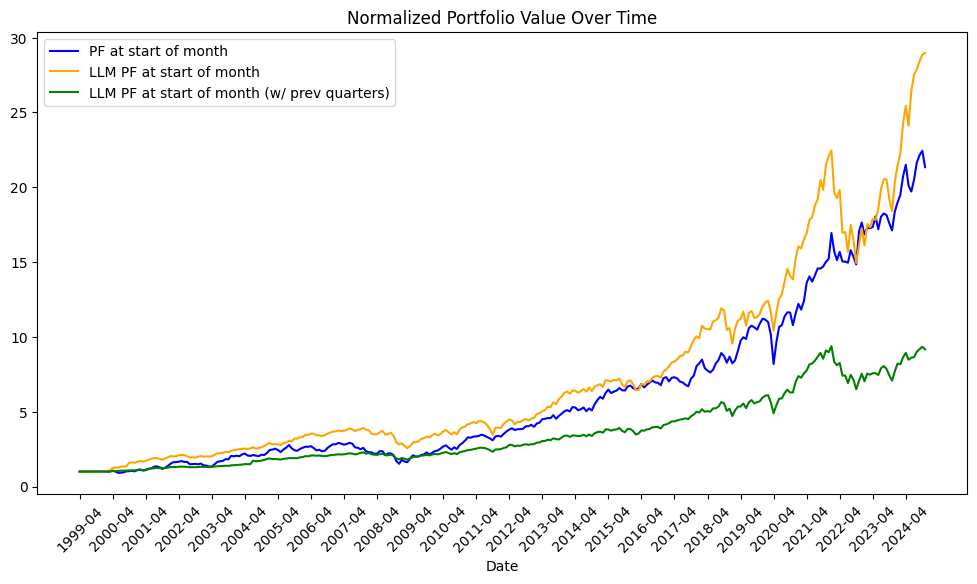

In [25]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.plot(dates, llm_returns['normalized_start_value'], label='LLM PF at start of month', color='orange')
plt.plot(dates, llm_returns2['normalized_start_value'], label='LLM PF at start of month (w/ prev quarters)', color='green')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.legend()
plt.show()

---